## Import libraries

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

In [2]:
from srs.analysis import read_data, plot_missing_values, plot_max_median, plot_correlation_between_stations, \
    remove_outliers, interpolate_missing_values, calculate_mean_value_across_all_stations, save_mean_data, \
    plot_change_between_consecutive_hours, plot_diff_between_stations

## Read data

In [3]:
data = read_data('NOx')
stations = data.columns.tolist()[1:]

In [4]:
stations

['WpPoznDabrow', 'WpPoznPolank', 'WpPoznRatajeMOB']

In [5]:
data

Time  WpPoznDabrow  WpPoznPolank  WpPoznRatajeMOB
0    2020-01-01 00:00:00       9.40492       13.2360          6.28479
1    2020-01-01 01:00:00      10.02100       11.9810          6.45490
2    2020-01-01 02:00:00       8.88761       12.6818          8.68450
3    2020-01-01 03:00:00       8.30498       11.0142          6.91294
4    2020-01-01 04:00:00       7.34898        9.9928          6.51036
...                  ...           ...           ...              ...
8779 2020-12-31 19:00:00      75.90060       49.4568         92.63800
8780 2020-12-31 20:00:00      54.40490       42.8829         74.84210
8781 2020-12-31 21:00:00      47.11650       35.8852         91.79140
8782 2020-12-31 22:00:00      36.53730       33.5541         64.50240
8783 2020-12-31 23:00:00      37.17030       25.3400         24.40460

[8784 rows x 4 columns]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Time             8784 non-null   datetime64[ns]
 1   WpPoznDabrow     8680 non-null   float64       
 2   WpPoznPolank     8691 non-null   float64       
 3   WpPoznRatajeMOB  8767 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 274.6 KB


In [7]:
data.describe().T

count       mean        std      min       25%      50%  \
WpPoznDabrow     8680.0  28.214186  41.489184  0.30000  10.00655  17.1992   
WpPoznPolank     8691.0  27.556171  28.680212  1.87695  11.27715  19.0125   
WpPoznRatajeMOB  8767.0  22.174021  25.011541  1.42232   8.74793  14.8881   

                       75%      max  
WpPoznDabrow     30.906825  739.589  
WpPoznPolank     33.425250  516.459  
WpPoznRatajeMOB  26.163050  410.609

### Investigate missing values

In [8]:
data.isnull().mean().round(3)

Time               0.000
WpPoznDabrow       0.012
WpPoznPolank       0.011
WpPoznRatajeMOB    0.002
dtype: float64

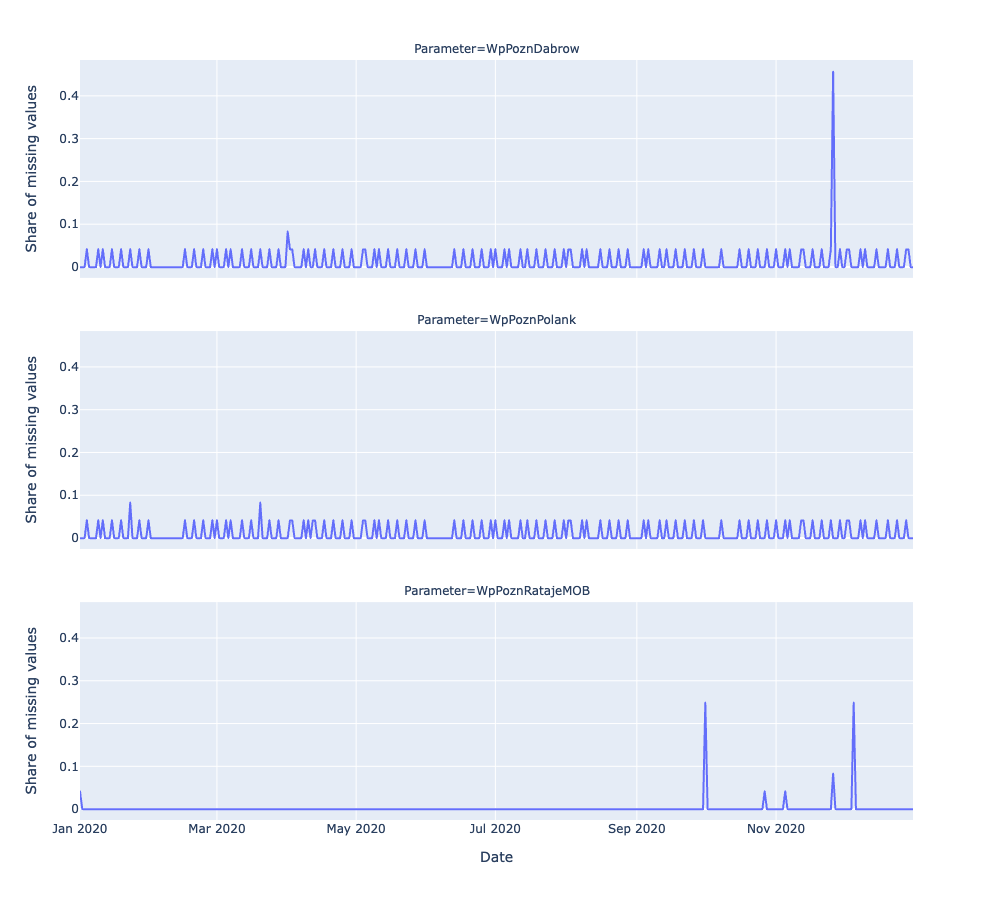

In [9]:
plot_missing_values(data, stations)

The missing values are spread throught the whole data range, these should be easy to interpolate.

## EDA

**Maximum and median values**

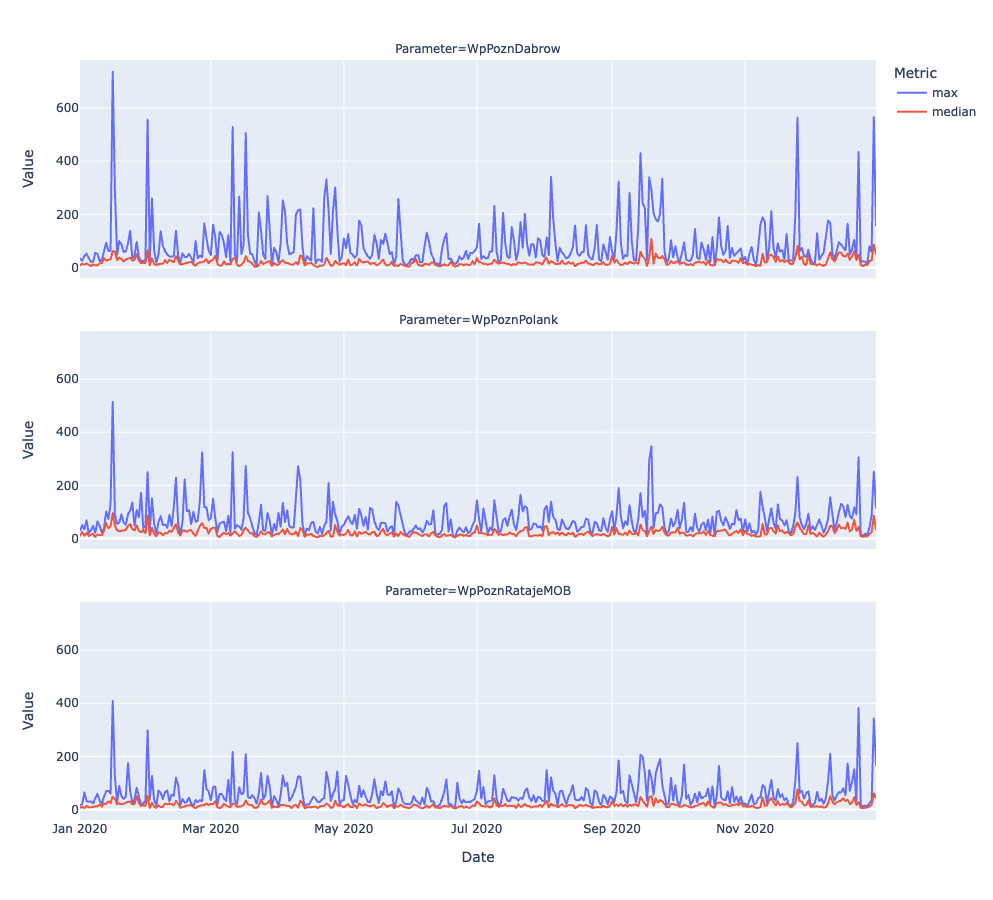

In [10]:
plot_max_median(data, stations)

It looks like there are just moments throughout the day when the concentration is very high, but it does not last long.

**Correlation between stations**

The data has to be transformed for the pattern to occur.

In [11]:
data_log = data.copy()

for s in stations:
    data_log[s] = np.log(data[s])

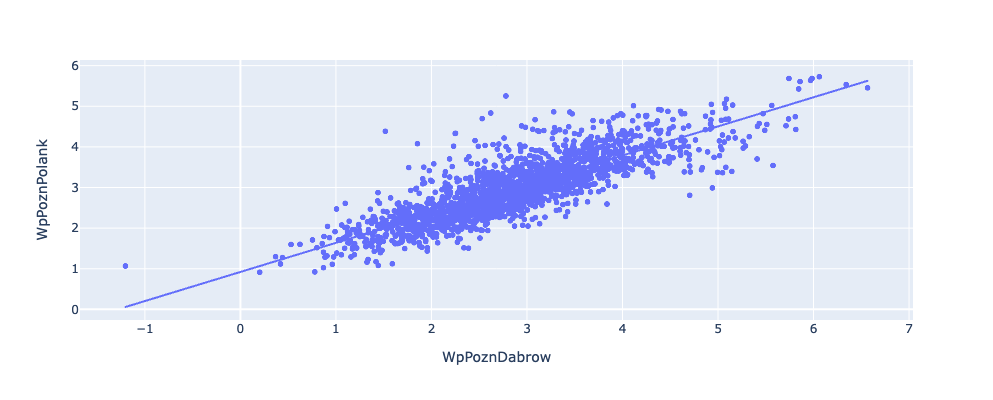

In [12]:
plot_correlation_between_stations(data_log, stations[0], stations[1])

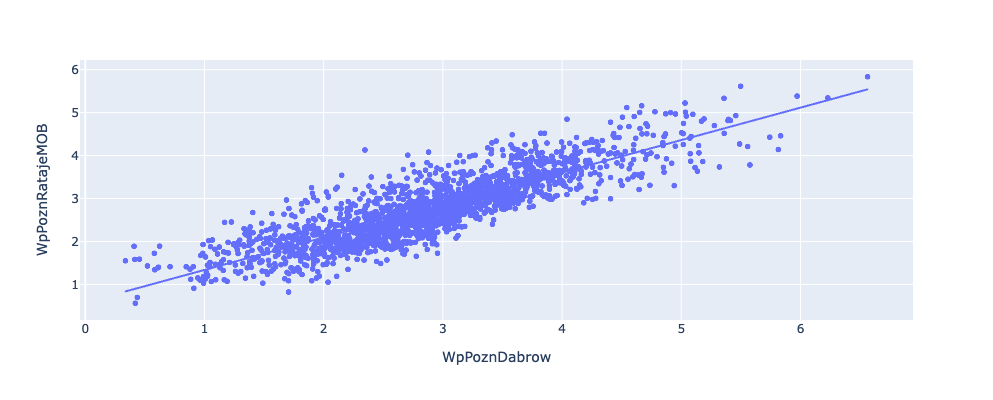

In [13]:
plot_correlation_between_stations(data_log, stations[0], stations[2])

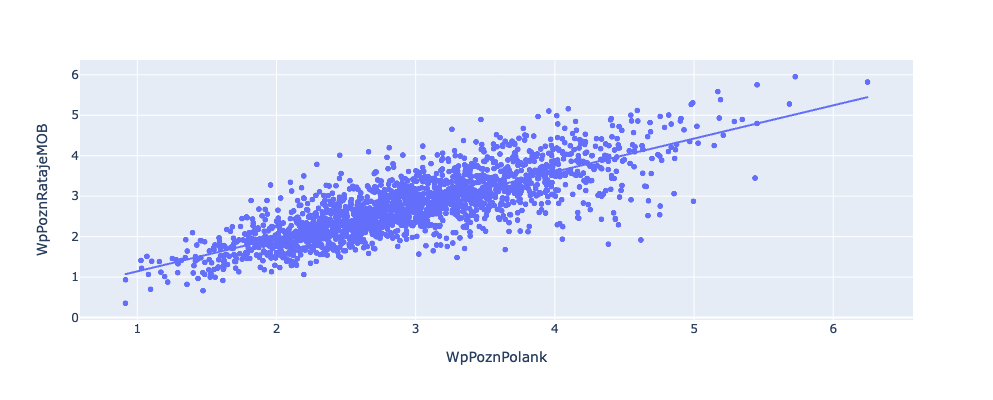

In [14]:
plot_correlation_between_stations(data_log, stations[1], stations[2])

What's interesting, the measurements of stations are not linearly correlated. I had to make logarytmic transformation to see the pattern.

**Change between consecutive hours**

                Difference                              
                      mean   median       max        std
Parameter                                               
WpPoznDabrow     -0.007778 -0.16677  459.4780  23.638698
WpPoznPolank     -0.009590 -0.16980  202.4380  15.543758
WpPoznRatajeMOB  -0.005538 -0.21880  216.6737  12.889048


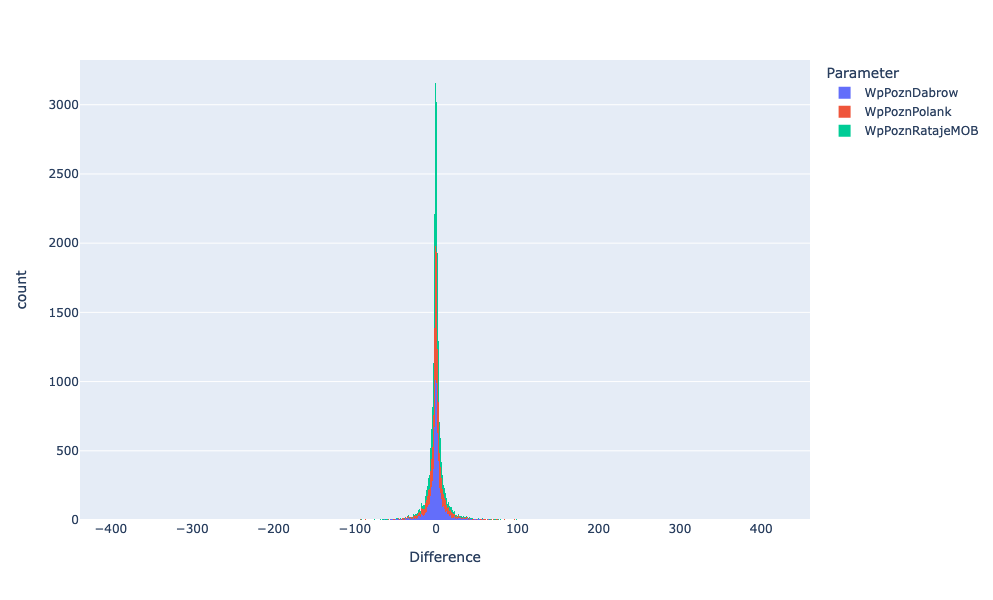

In [15]:
plot_change_between_consecutive_hours(data, stations)

This distribution is not surprising after the observation we made when analysing max and median values. There rapid changes in pollution which happen from time to time.

**Difference between stations**

mean       -0.697799
median      1.242670
max       296.394200
std        27.983078
Name: Difference, dtype: float64


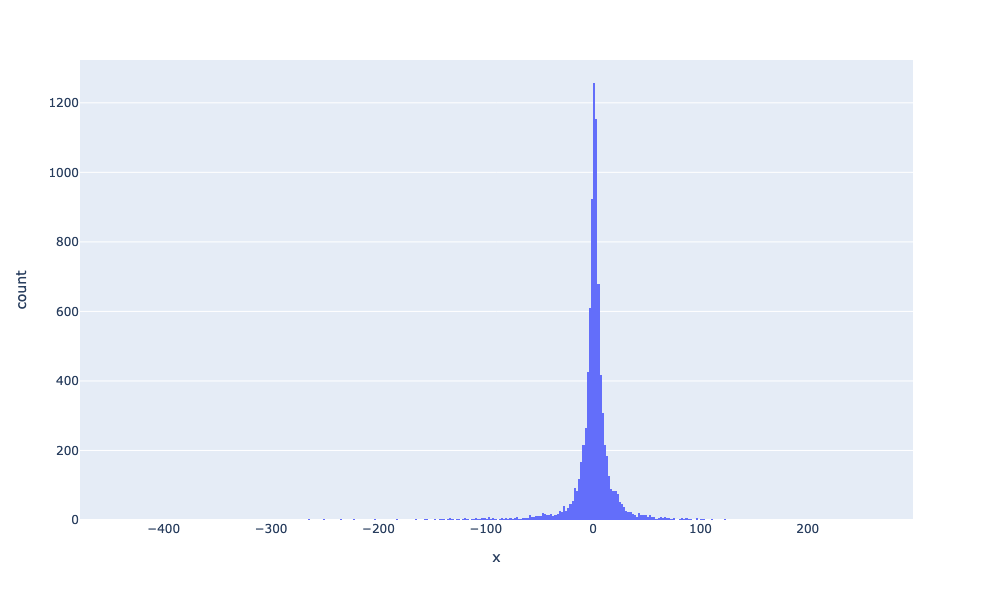

In [16]:
plot_diff_between_stations(data, stations[0], stations[1])

mean       -6.097548
median     -2.407000
max       177.743000
std        25.556678
Name: Difference, dtype: float64


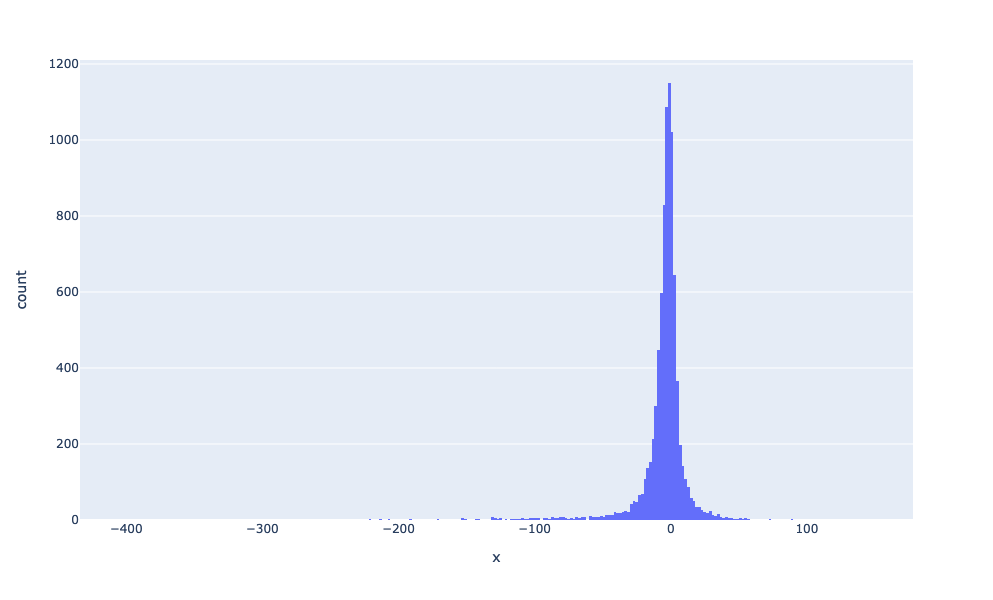

In [17]:
plot_diff_between_stations(data, stations[0], stations[2])

mean       -5.388964
median     -2.964750
max       190.188400
std        20.227341
Name: Difference, dtype: float64


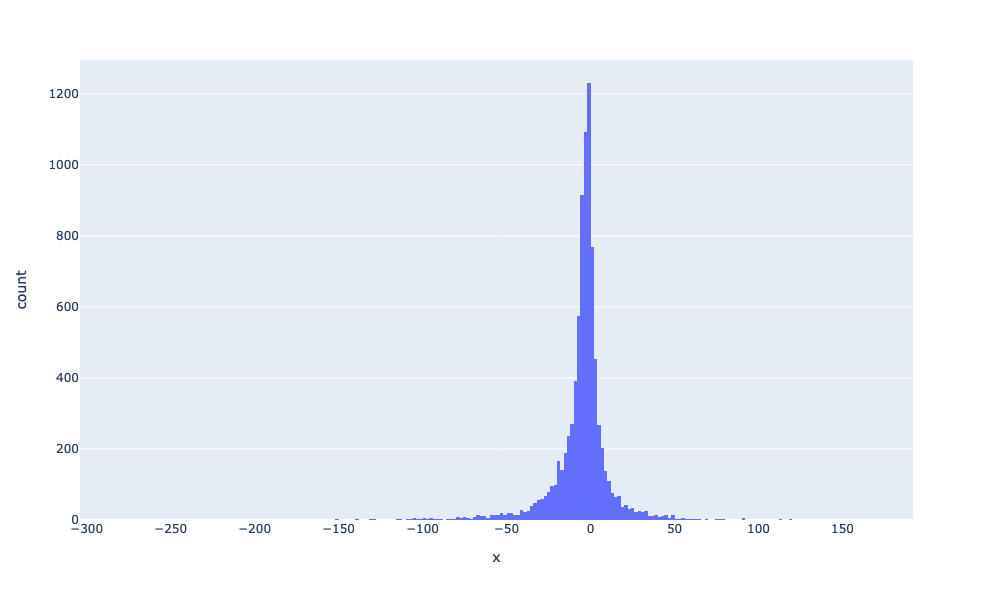

In [18]:
plot_diff_between_stations(data, stations[1], stations[2])

There is a factor which disturbes the normal distribution and skews it towards one side.

## Remove outliers

As there are many sudden changes in data, removing outliers is more tricky here. I will increase the threshold to not remove valuable information.

In [26]:
data_rm_outliers = remove_outliers(data, stations, num_std=6)
data_rm_outliers = interpolate_missing_values(data_rm_outliers, stations)

67 outliers removed for WpPoznDabrow
17 outliers removed for WpPoznPolank
2 outliers removed for WpPoznRatajeMOB
154 values interpolated for WpPoznDabrow
110 values interpolated for WpPoznPolank
13 values interpolated for WpPoznRatajeMOB


The interploation filled missing data only up to 3 concurrent hours and this limit was chosen based on intuiton of the analyst.

How many missing values are left?

In [27]:
data.isnull().sum()

Time                 0
WpPoznDabrow       104
WpPoznPolank        93
WpPoznRatajeMOB     17
dtype: int64

In [28]:
data_rm_outliers.isnull().sum()

Time                0
WpPoznDabrow       17
WpPoznPolank        0
WpPoznRatajeMOB     6
dtype: int64

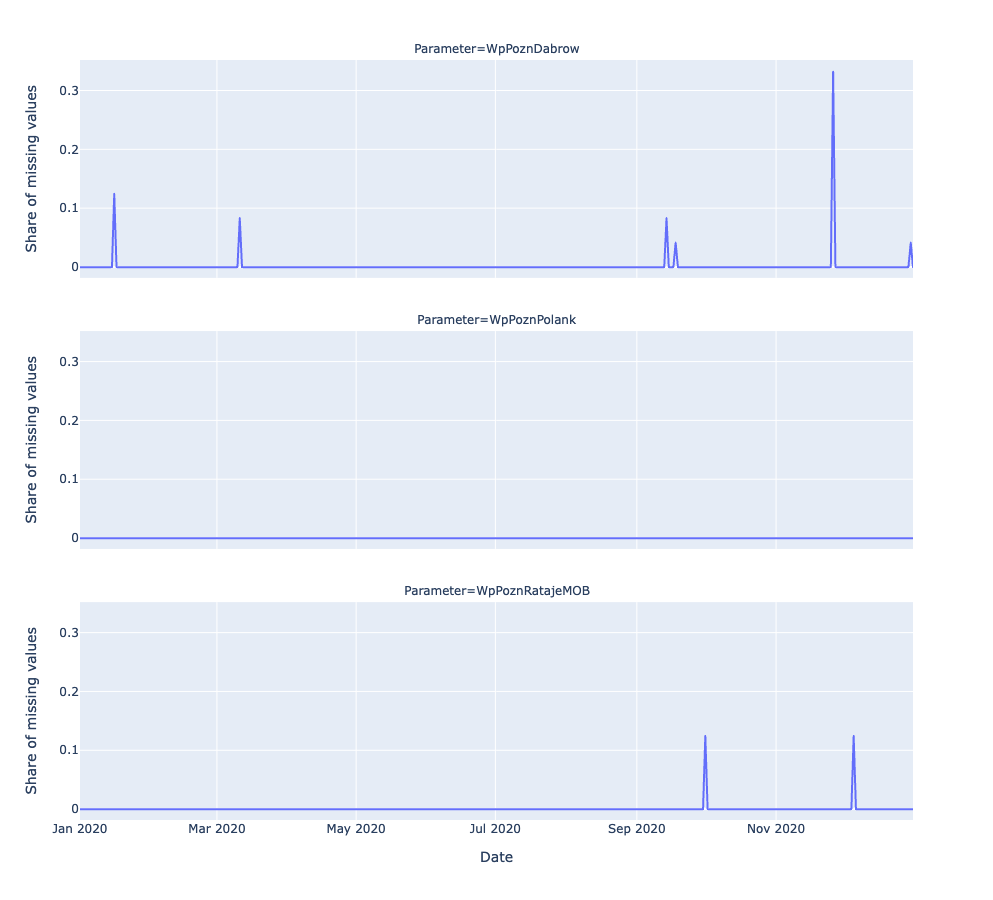

In [29]:
plot_missing_values(data_rm_outliers, stations)

## Calculate final mean value across all the stations

In [30]:
data_mean = calculate_mean_value_across_all_stations(data_rm_outliers, 'NOx')

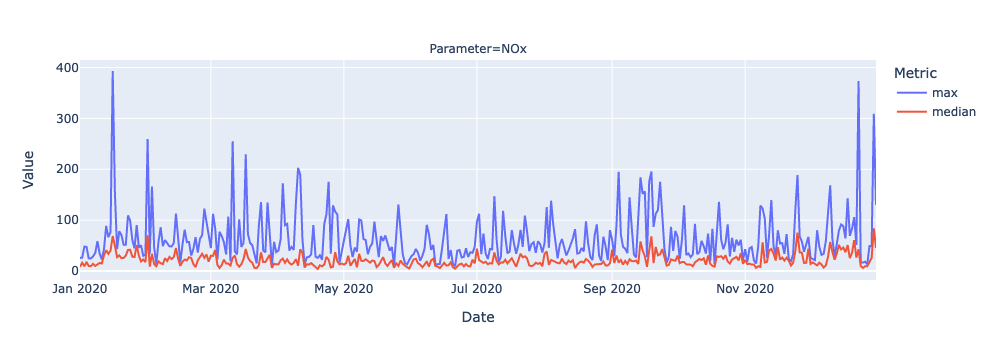

In [31]:
plot_max_median(data_mean, ['NOx'])

In [32]:
data_mean.isnull().sum()

Time    0
NOx     0
dtype: int64

With data from both stations we covered the entire year.

**Save mean data**

In [33]:
save_mean_data(data_mean, 'NOx')